In [3]:
! pip install pytorch-ignite

     |████████████████████████████████| 232 kB 5.4 MB/s 


In [4]:
import ignite

In [5]:
print(f'ignite version: {ignite.__version__}')

ignite version: 0.4.6


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [7]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

In [8]:
print(torch.__version__)

1.9.0+cu102


In [9]:
def get_data_sample():
    batch_size = 128
    transform_fn = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
    
    trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform_fn)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform_fn)
    val_loader = DataLoader(validationset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

In [10]:
train_loader, val_loader = get_data_sample()
# print(train_loader.dataset)
print(f"train data information: {train_loader.dataset}")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

train data information: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
class ConvolutionNeuralNet(nn.Module):
    
    def __init__(self):
        super(ConvolutionNeuralNet, self).__init__()
        self.feature_1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.feature_2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_1 = nn.Linear(64 * 6 * 6, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc_2 = nn.Linear(600, 120)
        self.fc_3 = nn.Linear(120, 10)
    
    def forward(self, input_x):
        """
            이미지의 특징점을 찾아주는 네트워크
        """
        x = self.feature_1(input_x)
        x = self.feature_2(x)
        """
            찾아준 특징점을 가지고 이미지를 분류하는 네트워크
        """
        x = x.view(-1, 64 * 6 * 6)
        x = self.fc_1(x)
        x = self.drop(x)
        x = self.fc_2(x)
        x = self.fc_3(x)

        return F.log_softmax(x, dim=1)

In [12]:
train_loader, val_loader = get_data_sample()

In [13]:
model = ConvolutionNeuralNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optim = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.NLLLoss()

In [14]:
"""
    학습을할 operation 평가를할 operation
"""
metrics = {
    'accuracy': Accuracy(),
    'nll': Loss(loss_fn),
    'cm': ConfusionMatrix(num_classes=10)
}
trainer = create_supervised_trainer(model, optim, loss_fn, device=device)
"""
    train_evaluator: 현재 학습하는데이터로 평가를 했을 경우
    val_evaluator:  학데이터로 평가를 했을 경우
"""
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

training_history = {'accuracy': [], 'loss': []}
validation_history = {'accuracy': [], 'loss': []}

last_epoch = []

In [15]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [16]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

In [17]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)

    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy'] * 100
    loss = metrics['nll']
    last_epoch.append(0)
    """
        log visualzation (loss function value, accuracy value)
    """
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print(f"Training Results - Epoch {trainer.state.epoch} Avg accuracy: {accuracy}, Avg loss: {loss:.4f}")

In [18]:
def log_validation_results(trainer):
    val_evaluator.run(val_loader)

    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy'] * 100
    loss = metrics['nll']

    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print(f"Validation Results - Epoch: {val_evaluator.state.epoch} Avg accuracy: {accuracy}, Avg loss: {loss:.4f}")

In [19]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="d")
    """
        Ture Label, Prediction Label
    """
    ax.set_xlabel('prediction labels')
    ax.set_ylabel('true labels')
    ax.set_title('confusion matirx')
    ax.xaxis.set_ticklabels(classes, rotation=90)
    ax.yaxis.set_ticklabels(classes, rotation=0)

In [20]:
handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1/469]   0%|           [00:00<?]

Training Results - Epoch 1 Avg accuracy: 87.83666666666666, Avg loss: 0.3300
Validation Results - Epoch: 1 Avg accuracy: 86.45, Avg loss: 0.3724


[1/469]   0%|           [00:00<?]

Training Results - Epoch 2 Avg accuracy: 91.60333333333334, Avg loss: 0.2363
Validation Results - Epoch: 1 Avg accuracy: 89.83, Avg loss: 0.2866


[1/469]   0%|           [00:00<?]

Training Results - Epoch 3 Avg accuracy: 91.55, Avg loss: 0.2269
Validation Results - Epoch: 1 Avg accuracy: 89.52, Avg loss: 0.2872


[1/469]   0%|           [00:00<?]

Training Results - Epoch 4 Avg accuracy: 91.67333333333333, Avg loss: 0.2311
Validation Results - Epoch: 1 Avg accuracy: 89.03, Avg loss: 0.3075


[1/469]   0%|           [00:00<?]

Training Results - Epoch 5 Avg accuracy: 94.03166666666667, Avg loss: 0.1674
Validation Results - Epoch: 1 Avg accuracy: 90.96, Avg loss: 0.2502


[1/469]   0%|           [00:00<?]

Training Results - Epoch 6 Avg accuracy: 93.04333333333334, Avg loss: 0.1879
Validation Results - Epoch: 1 Avg accuracy: 90.16, Avg loss: 0.2825


[1/469]   0%|           [00:00<?]

Training Results - Epoch 7 Avg accuracy: 93.17333333333333, Avg loss: 0.1894
Validation Results - Epoch: 1 Avg accuracy: 90.12, Avg loss: 0.2848


[1/469]   0%|           [00:00<?]

Training Results - Epoch 8 Avg accuracy: 94.44, Avg loss: 0.1533
Validation Results - Epoch: 1 Avg accuracy: 91.12, Avg loss: 0.2723


[1/469]   0%|           [00:00<?]

Training Results - Epoch 9 Avg accuracy: 93.32666666666667, Avg loss: 0.1917
Validation Results - Epoch: 1 Avg accuracy: 89.66, Avg loss: 0.3251


[1/469]   0%|           [00:00<?]

Training Results - Epoch 10 Avg accuracy: 95.82166666666667, Avg loss: 0.1202
Validation Results - Epoch: 1 Avg accuracy: 91.42, Avg loss: 0.2620


State:
	iteration: 4690
	epoch: 10
	epoch_length: 469
	max_epochs: 10
	output: 0.12645648419857025
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

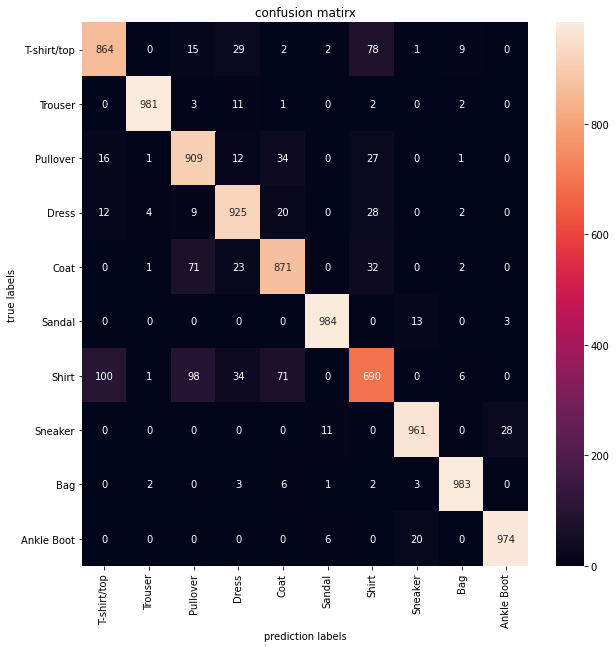

In [21]:
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"batch loss": x})
trainer.run(train_loader, max_epochs=10)

In [22]:
print(val_loader.dataset)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


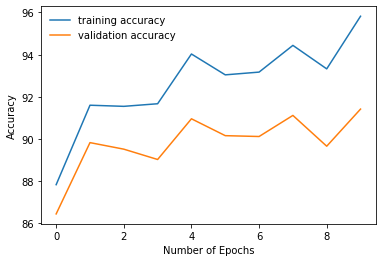

In [28]:
plt.plot(training_history['accuracy'], label='training accuracy')
plt.plot(validation_history['accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

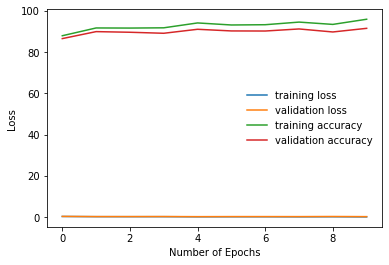

In [30]:
plt.plot(training_history['loss'], label='training loss')
plt.plot(validation_history['loss'], label='validation loss')
plt.plot(training_history['accuracy'], label='training accuracy')
plt.plot(validation_history['accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

In [31]:
import os
def fetch_last_checkpoint_model_filename(model_save_path):
    ckpt_files = os.listdir(model_save_path)
    ckpt_files = [f for f in ckpt_files if '.pt' in f]
    ckpt_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in ckpt_files]
    last_idx = np.array(ckpt_iter).argmax()
    
    return os.path.join(torch.load(model_save_path, ckpt_files[last_idx]))

In [32]:
model = model.to('cpu')

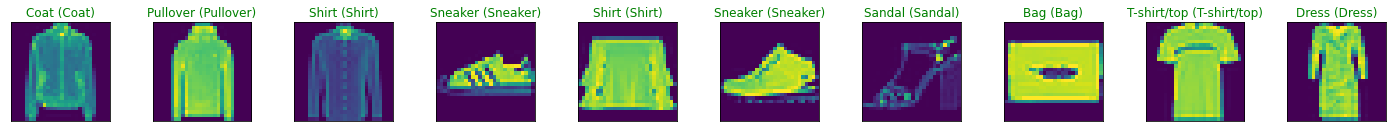

In [47]:
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
dataiter = iter(val_loader)
input_test_images, input_test_labels = dataiter.next()
images_arr = []
labels_arr = []
pred_arr = []

for idx in range(0, 10):
    images_arr.append(input_test_images[idx].unsqueeze(0))
    labels_arr.append(input_test_labels[idx].item())
    
    ps = torch.exp(model(images_arr[idx]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))

fig = plt.figure(figsize=(25, 4))
for idx in range(10):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(images_arr[idx].resize_(1, 28, 28).numpy().squeeze())
    ax.set_title(f"{classes[pred_arr[idx]]} ({classes[labels_arr[idx]]})", color=('green' if pred_arr[idx] == labels_arr[idx] else 'red'))